In [154]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as pltcolor
import netCDF4 as nc
import numpy as np
import xarray as xr
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

# Set-up

In [155]:
NUM_COLORS = 2019 - 2007 + 1 + 2

cmap = plt.get_cmap('gist_ncar')
cNorm  = pltcolor.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cmap)

In [156]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]
print (deptht.shape)

(40,)


## Month

In [157]:
month = 'jan'
imonth = '01'
nicemonth = 'January'

In [158]:
years = ['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']
allyears = np.arange(2007, 2020, dtype=int)
allyears

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019])

# Functions

In [159]:
def surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2, twoD=False):
    fig, axs = plt.subplots(2, 14, figsize=(20, 9))

    dm = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_'
                     +month+'_climate_2007_2019_'+file+'_T.nc')
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, 0], mask=1-tmask[0, 0])
        
    if file == 'turb':
        file2 = 'carp'
    else:
        file2 = file

    colours = axs[0, 13].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0, 13].set_title('Mean\n 2007-2019')
    cbar = fig.colorbar(colours, ax=axs[0, :], orientation='horizontal', aspect=50, extend='both',
                shrink=0.5)
    cbar.set_label(cb1)


    for iy, year in enumerate(allyears):
        if str(year) in years:
            ym = str(year) + imonth
            if year >= 2013:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')

            else:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/longhind.201905/SalishSea_1m_'+
                                      ym+'_'+ym+'_'+file2+'_T.nc')

            if twoD:
                field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
            else:
                field = np.ma.array(ds[tracer][0, 0], mask=1-tmask[0,0])
                
            colours = axs[0, iy].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
            axs[0, iy].set_title(year)
            colours = axs[1, iy].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
            ds.close()
    cbar = fig.colorbar(colours, ax=axs[1, :], orientation='horizontal', aspect=50, extend='both',
                shrink=0.5)
    cbar.set_label(cb2)
    for ax in axs[0]:
        ax.axis('off')
        viz_tools.set_aspect(ax)
    for ax in axs[1]:
        ax.axis('off')
        viz_tools.set_aspect(ax)
            
    dm.close()
    fig.suptitle('Averages for '+nicemonth, fontsize=14)
    return fig

In [160]:
def profiles(tracer, file):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    dm = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_'
                     +month+'_climate_2007_2019_'+file+'_T.nc')
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Mean')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Mean')
    
    if file == 'turb':
        file2 = 'carp'
    else:
        file2 = file
        
    for iy, year in enumerate(allyears):
        if str(year) in years:
            ym = str(year) + imonth
            if year >= 2013:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')

            else:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/longhind.201905/SalishSea_1m_'+
                                      ym+'_'+ym+'_'+file2+'_T.nc')

    
            field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
            axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label=year, color=scalarMap.to_rgba(iy))
    
            axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label=year, color=scalarMap.to_rgba(iy))
            ds.close()

    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    fig.suptitle(tracer+' average for '+nicemonth)
   
    dm.close()
    return fig

In [161]:
def thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax):
    fig, axs = plt.subplots(14, 2, figsize=(15, 25))
    
        
    if file == 'turb':
        file2 = 'carp'
    else:
        file2 = file

    dm = xr.open_dataset('/data/sallen/results/MEOPAR/averages/SalishSea_'
                     +month+'_climate_2007_2019_'+file+'_T.nc')
    mean_field = np.array(dm[tracer][0])
    cbar = vis.contour_thalweg(axs[13, 0], mean_field, bathy, mesh,
                                  np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap, 
                               cbar_args={'orientation': 'horizontal'})
    axs[13, 0].set_title('Mean for 2007-2019')
    
    for iy, year in enumerate(allyears):
        if str(year) in years:
            ym = str(year) + imonth
            if year >= 2013:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/hindcast.201905/SalishSea_1m_'+
                                     ym+'_'+ym+'_'+file2+'_T.nc')

            else:
                ds = xr.open_dataset('/data/sallen/results/MEOPAR/averages/longhind.201905/SalishSea_1m_'+
                                      ym+'_'+ym+'_'+file2+'_T.nc')

  
            field = np.array(ds[tracer][0])
            cbar = vis.contour_thalweg(axs[iy, 0], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, 
                                        (vmax-vmin)/10.), cmap=cmap, cbar_args={'orientation': 'horizontal'})
            cbar.remove()

            axs[iy, 0].set_title(year)
            cbar = vis.contour_thalweg(axs[iy, 1], field-mean_field, bathy, mesh, 
                                          np.arange(-dvmax, 1.2*dvmax, dvmax/5), cmap=cdiff, cbar_args={'orientation': 'horizontal'})
            cbar.remove()

            ds.close()
    for ax in axs[:, 0]:
        ax.axis('off')
    for ax in axs[:, 1]:
        ax.axis('off')
        
    fig.suptitle('Averages for '+nicemonth)

    dm.close()
    return fig

# Surface Plots

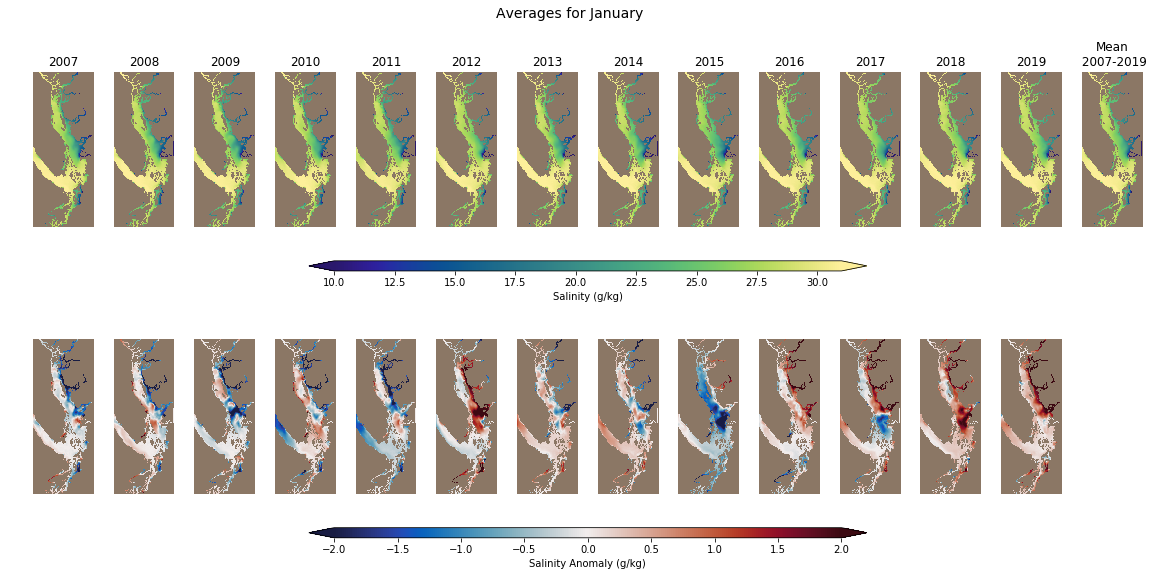

In [162]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cmap.set_bad('#8b7765')
cb1 = 'Salinity (g/kg)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Salinity Anomaly (g/kg)'
vmax = 31
vmin = 10
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

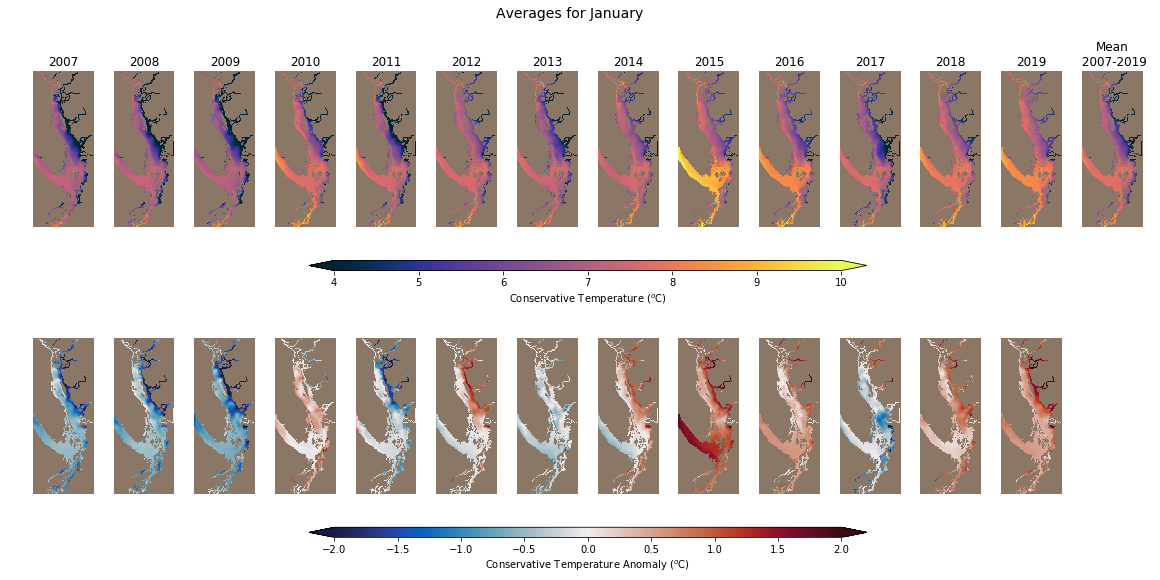

In [163]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cmap.set_bad('#8b7765')
cb1 = 'Conservative Temperature ($^o$C)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Conservative Temperature Anomaly ($^o$C)'
vmax = 10
vmin = 4
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

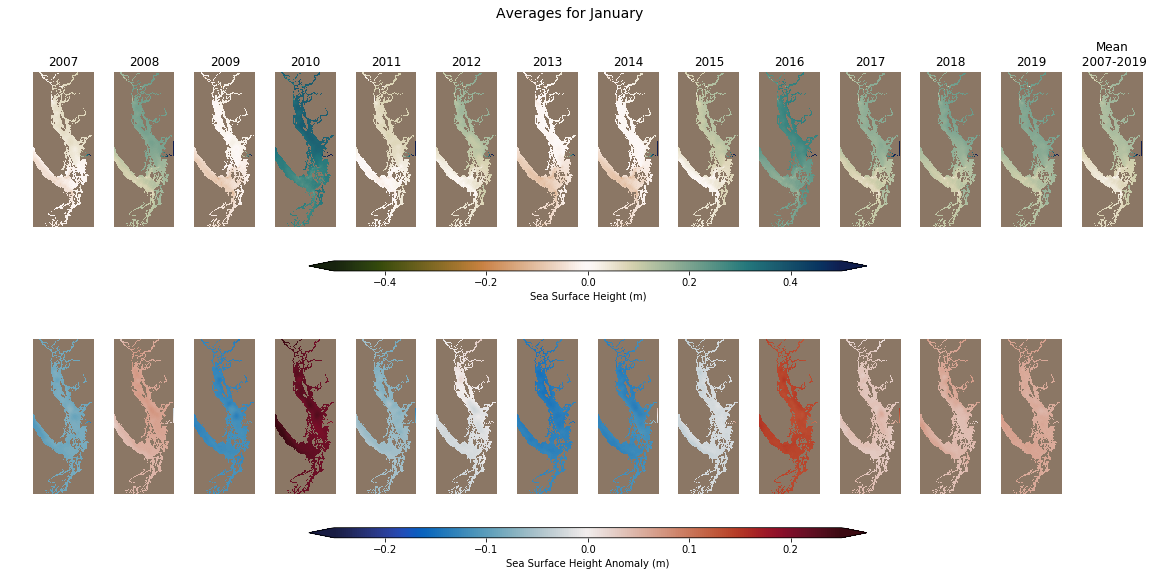

In [164]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cmap.set_bad('#8b7765')
cb1 = 'Sea Surface Height (m)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Sea Surface Height Anomaly (m)'
vmax = 0.5
vmin = -0.5
dvmax = 0.25
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2, twoD=True)
fig.savefig(tracer+'_'+month+'_surface.png')

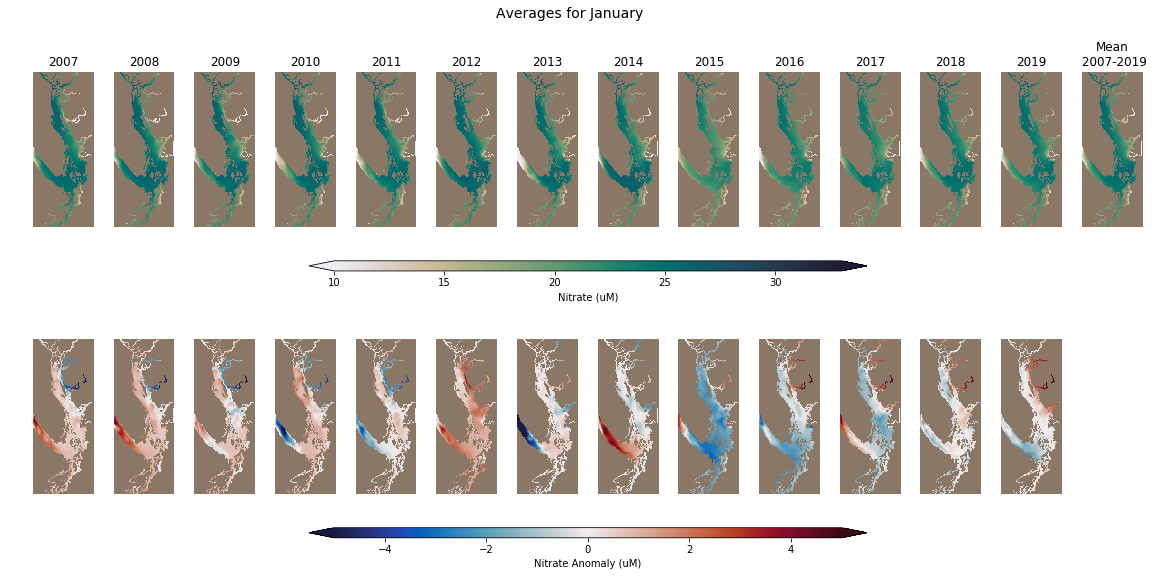

In [165]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cmap.set_bad('#8b7765')
cb1 = 'Nitrate (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Nitrate Anomaly (uM)'
vmax = 33
vmin = 10
dvmax = 5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

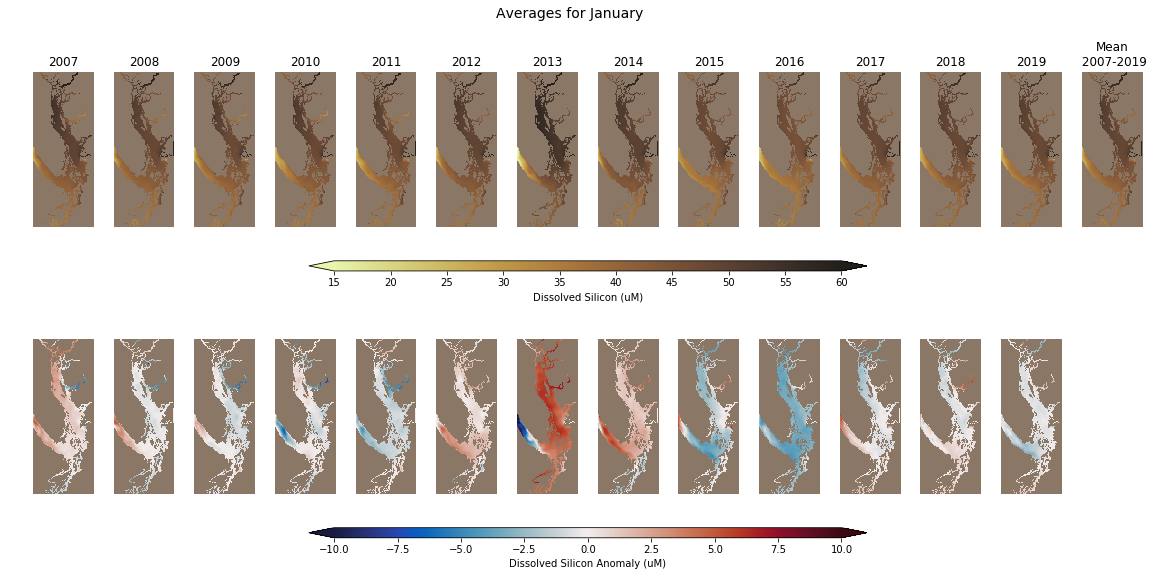

In [166]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cmap.set_bad('#8b7765')
cb1 = 'Dissolved Silicon (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Dissolved Silicon Anomaly (uM)'
vmax = 60
vmin = 15
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

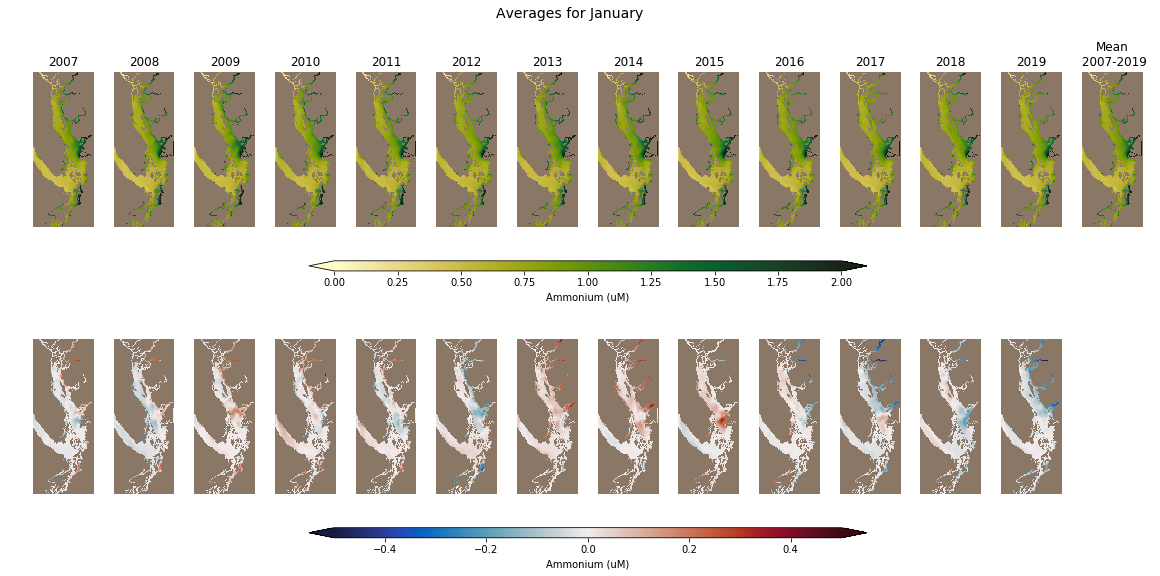

In [167]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cmap.set_bad('#8b7765')
cb1 = 'Ammonium (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Ammonium (uM)'
vmax = 2
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

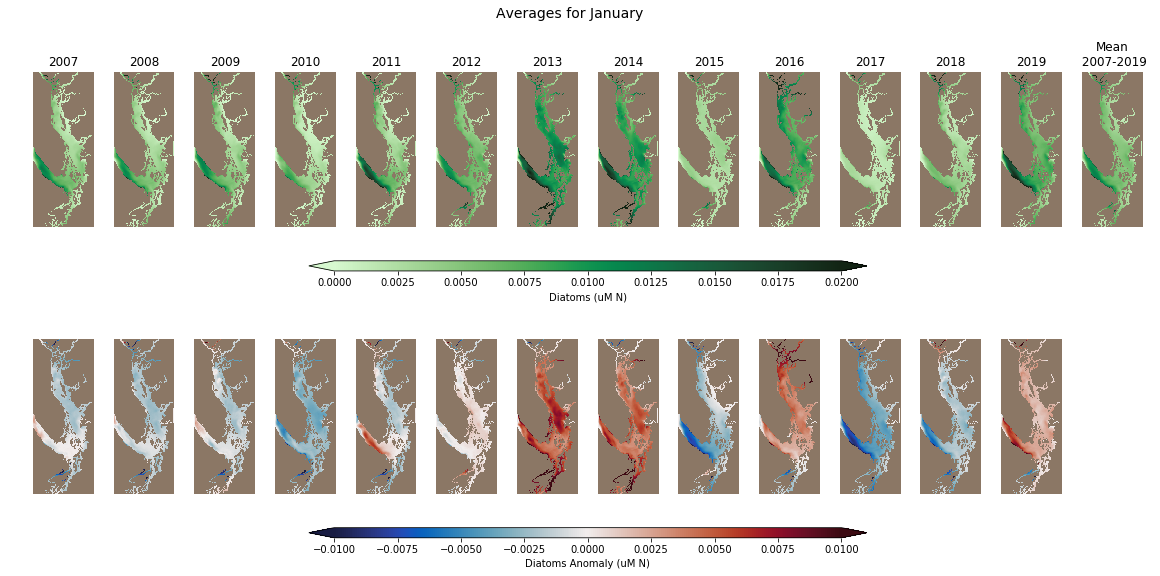

In [168]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cmap.set_bad('#8b7765')
cb1 = 'Diatoms (uM N)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = "Diatoms Anomaly (uM N)"
vmax = 0.02
vmin = 0
dvmax = 0.01
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

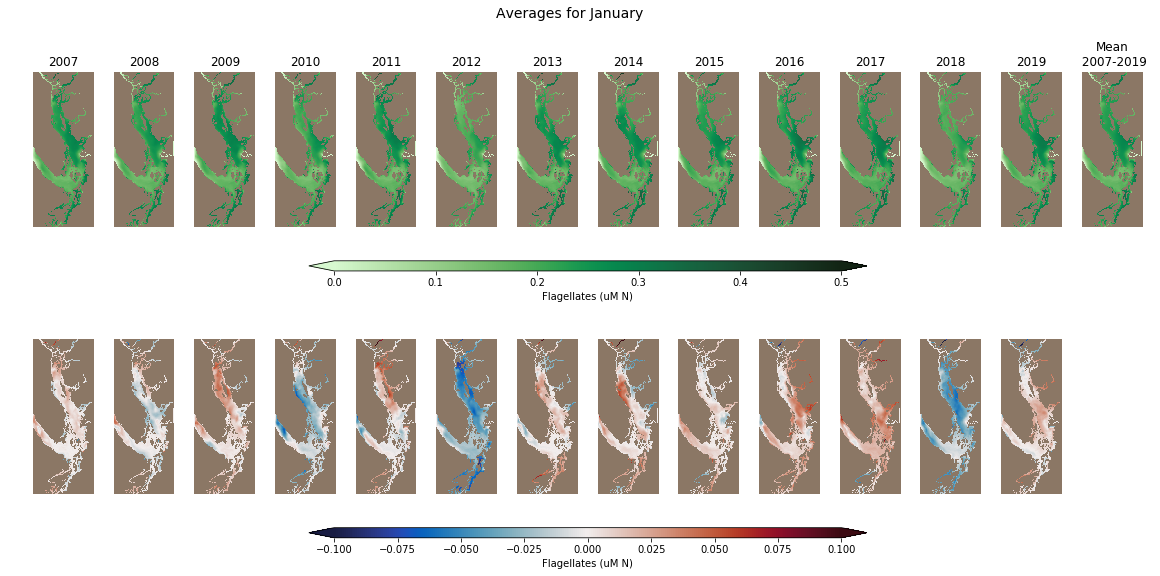

In [169]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cmap.set_bad('#8b7765')
cb1 = "Flagellates (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Flagellates (uM N)'
vmax = 0.5
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

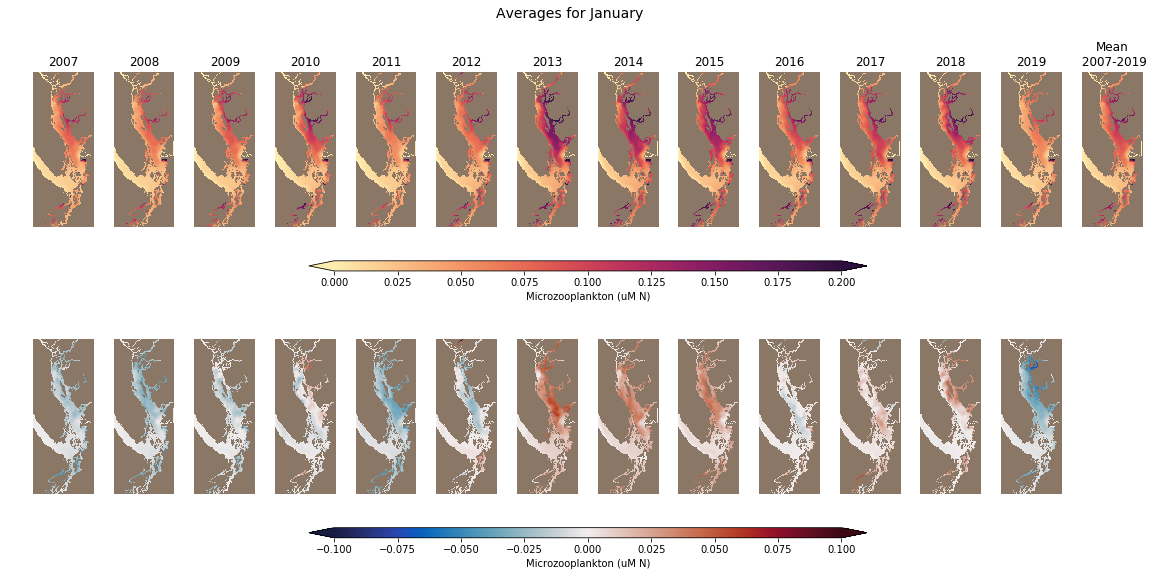

In [170]:
tracer = 'microzooplankton'
file = 'ptrc'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 0.2
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

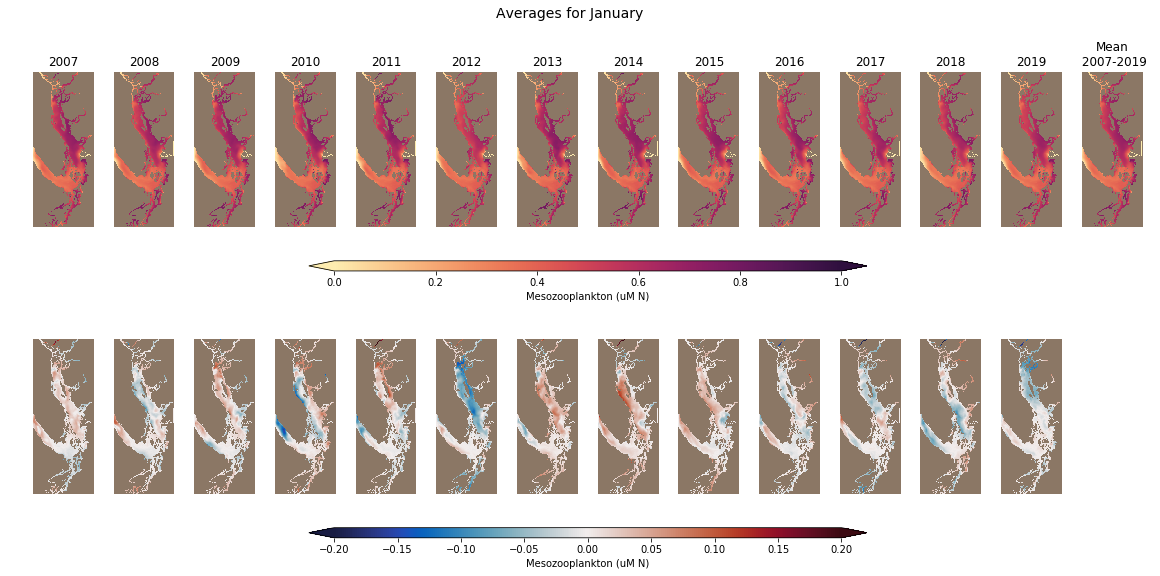

In [171]:
tracer = 'mesozooplankton'
file = 'ptrc'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Mesozooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Mesozooplankton (uM N)'
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

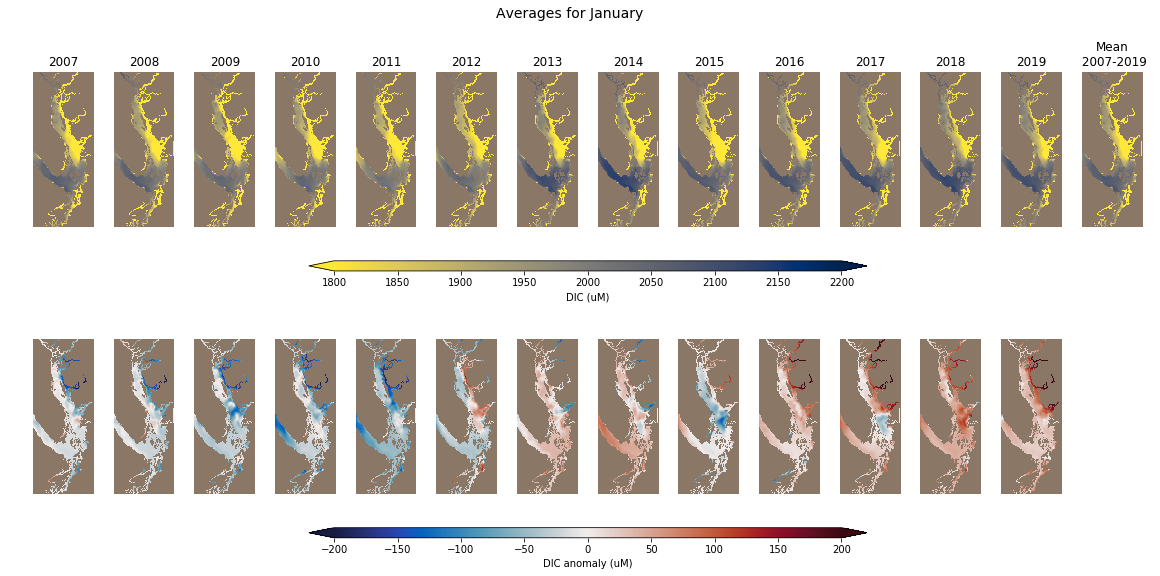

In [172]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = plt.get_cmap('cividis_r')
cmap.set_bad('#8b7765')
cb1 = 'DIC (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'DIC anomaly (uM)'
vmax = 2200
vmin = 1800
dvmax = 200
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

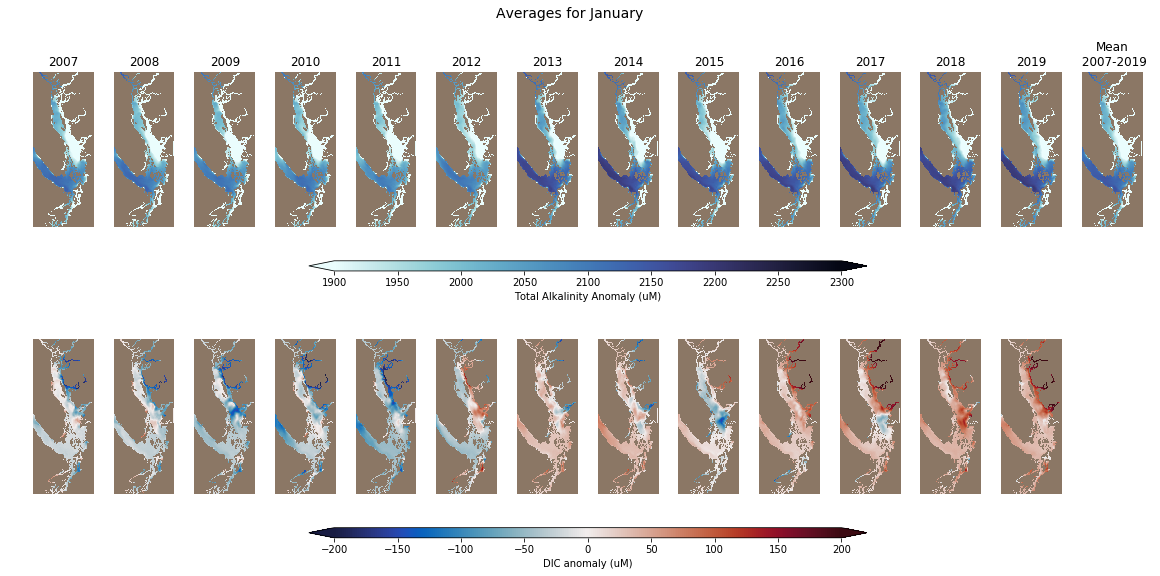

In [173]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cb1 = 'Total Alkalinity (uM)'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb1 = 'Total Alkalinity Anomaly (uM)'
vmax = 2300
vmin = 1900
dvmax = 200
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

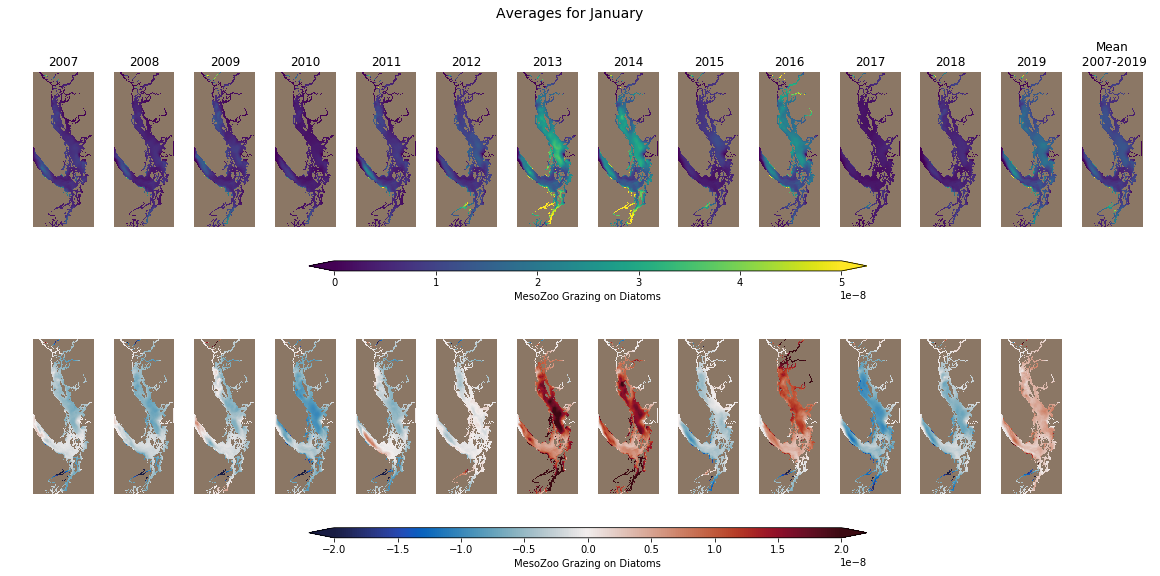

In [174]:
tracer = 'GRMESZDIAT'
file = 'dia2'
cmap = plt.get_cmap('viridis')
cmap.set_bad('#8b7765')
cb1 = 'MesoZoo Grazing on Diatoms'
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'MesoZoo Grazing on Diatoms'
vmax = 5e-8
vmin = 0
dvmax = 2e-8
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, cb1, cb2)
fig.savefig(tracer+'_'+month+'_surface.png')

# Profiles

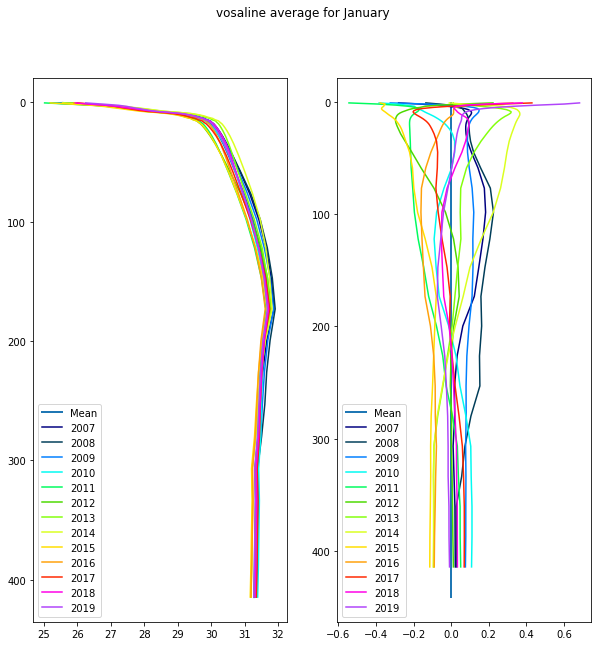

In [175]:
tracer = 'vosaline'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

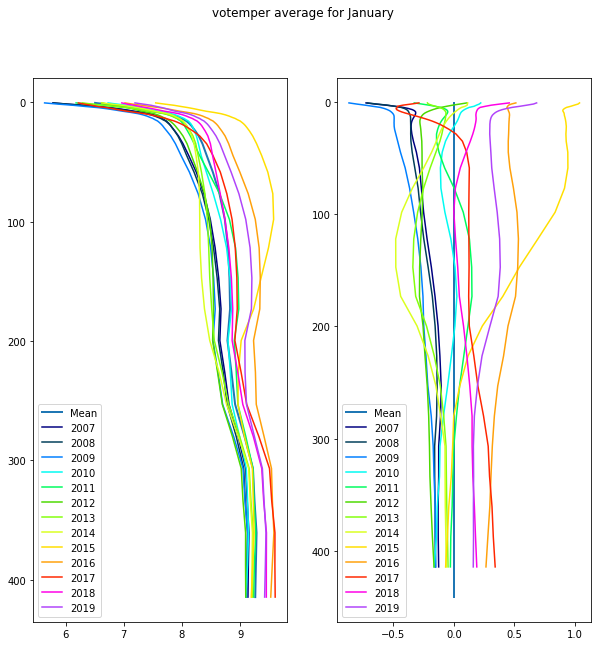

In [176]:
tracer = 'votemper'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

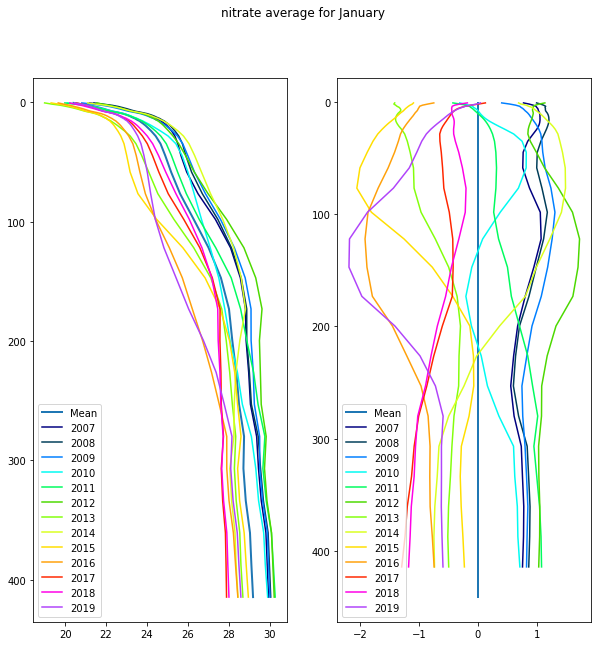

In [177]:
tracer = 'nitrate'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

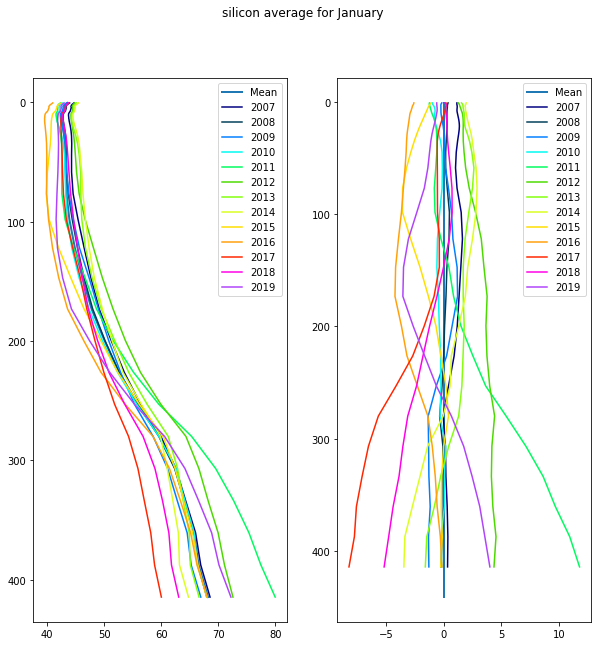

In [178]:
tracer = 'silicon'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

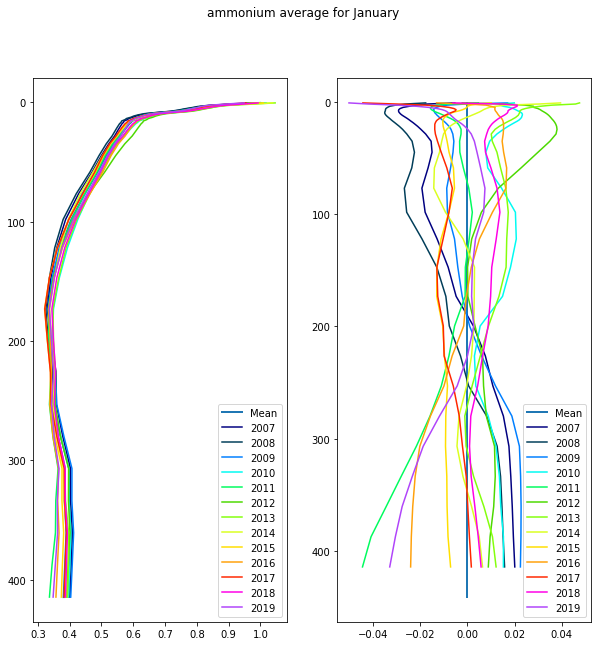

In [179]:
tracer = 'ammonium'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

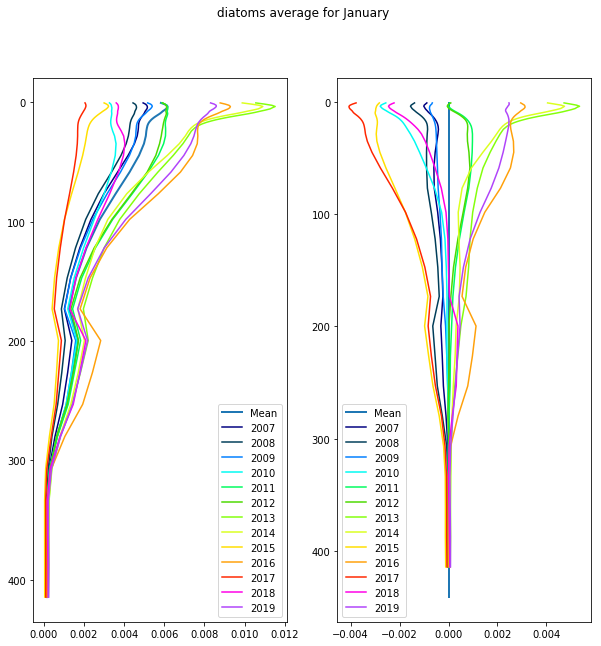

In [180]:
tracer = 'diatoms'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

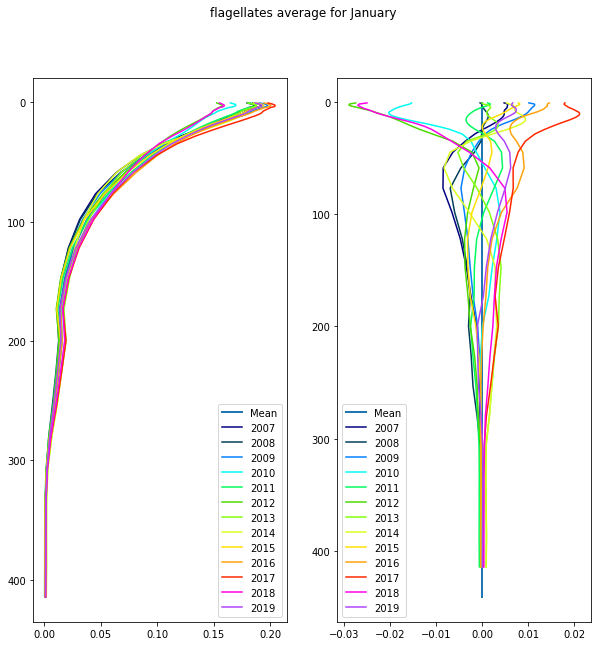

In [181]:
tracer = 'flagellates'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

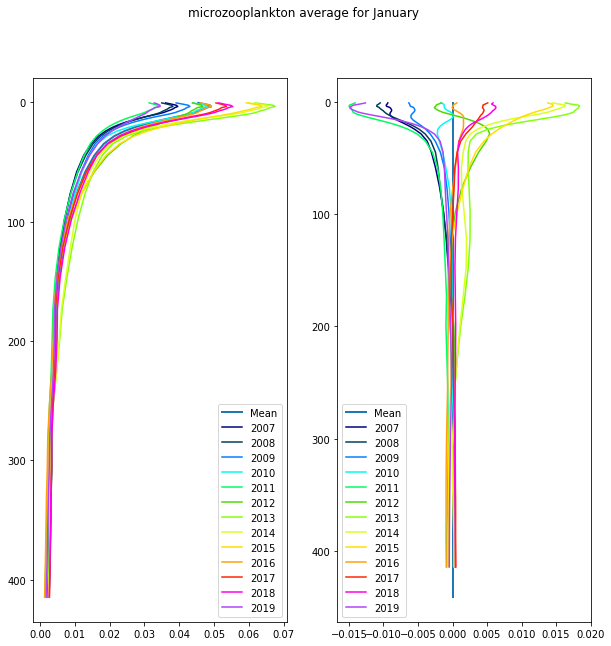

In [182]:
tracer = 'microzooplankton'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

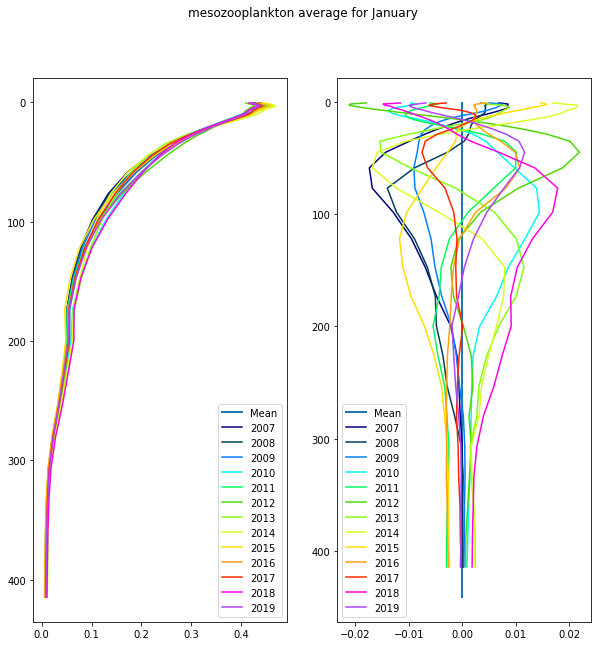

In [183]:
tracer = 'mesozooplankton'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

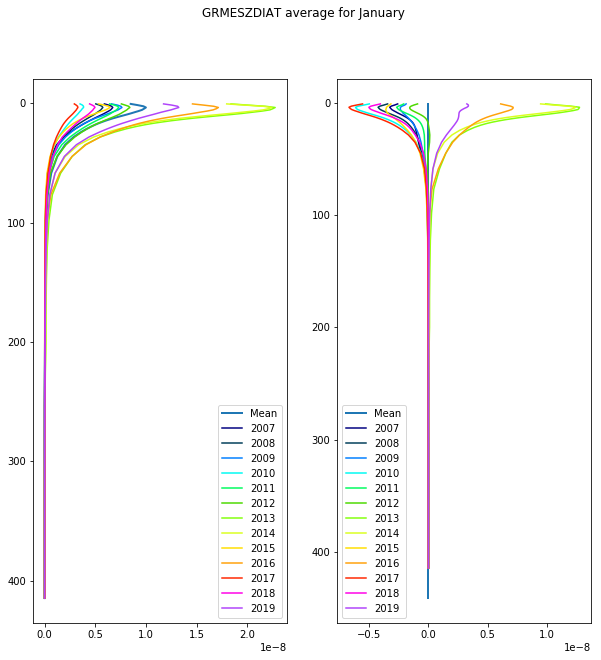

In [184]:
tracer = 'GRMESZDIAT'
file = 'dia2'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

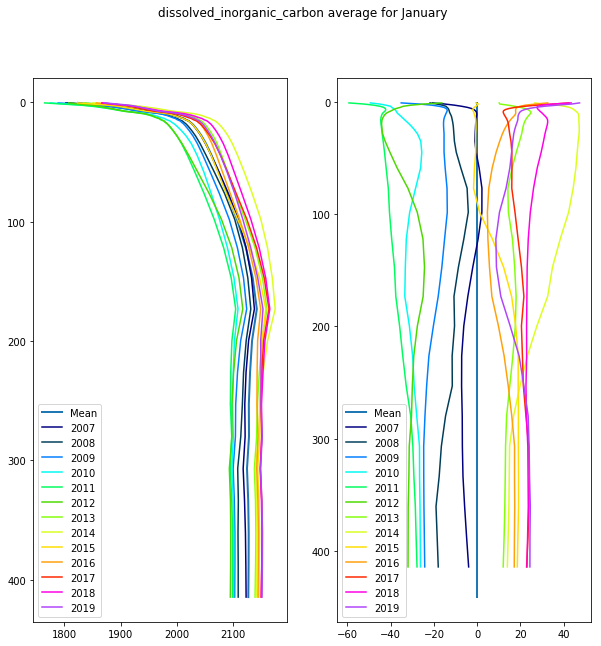

In [185]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

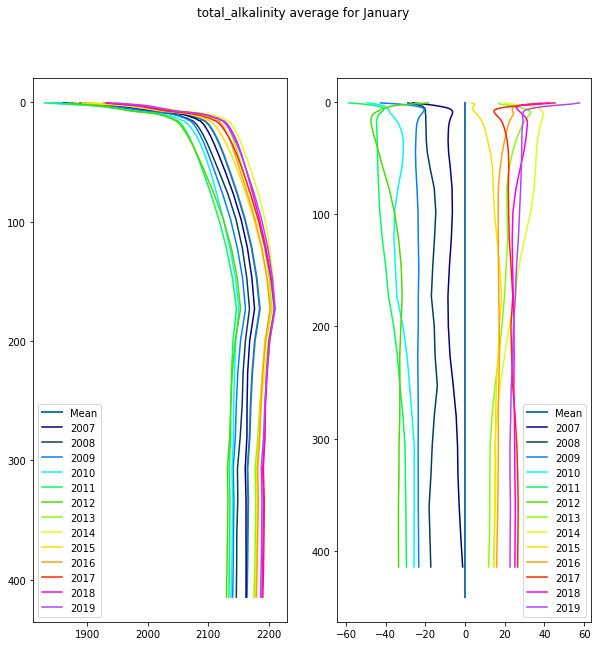

In [186]:
tracer = 'total_alkalinity'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

# Thalwegs

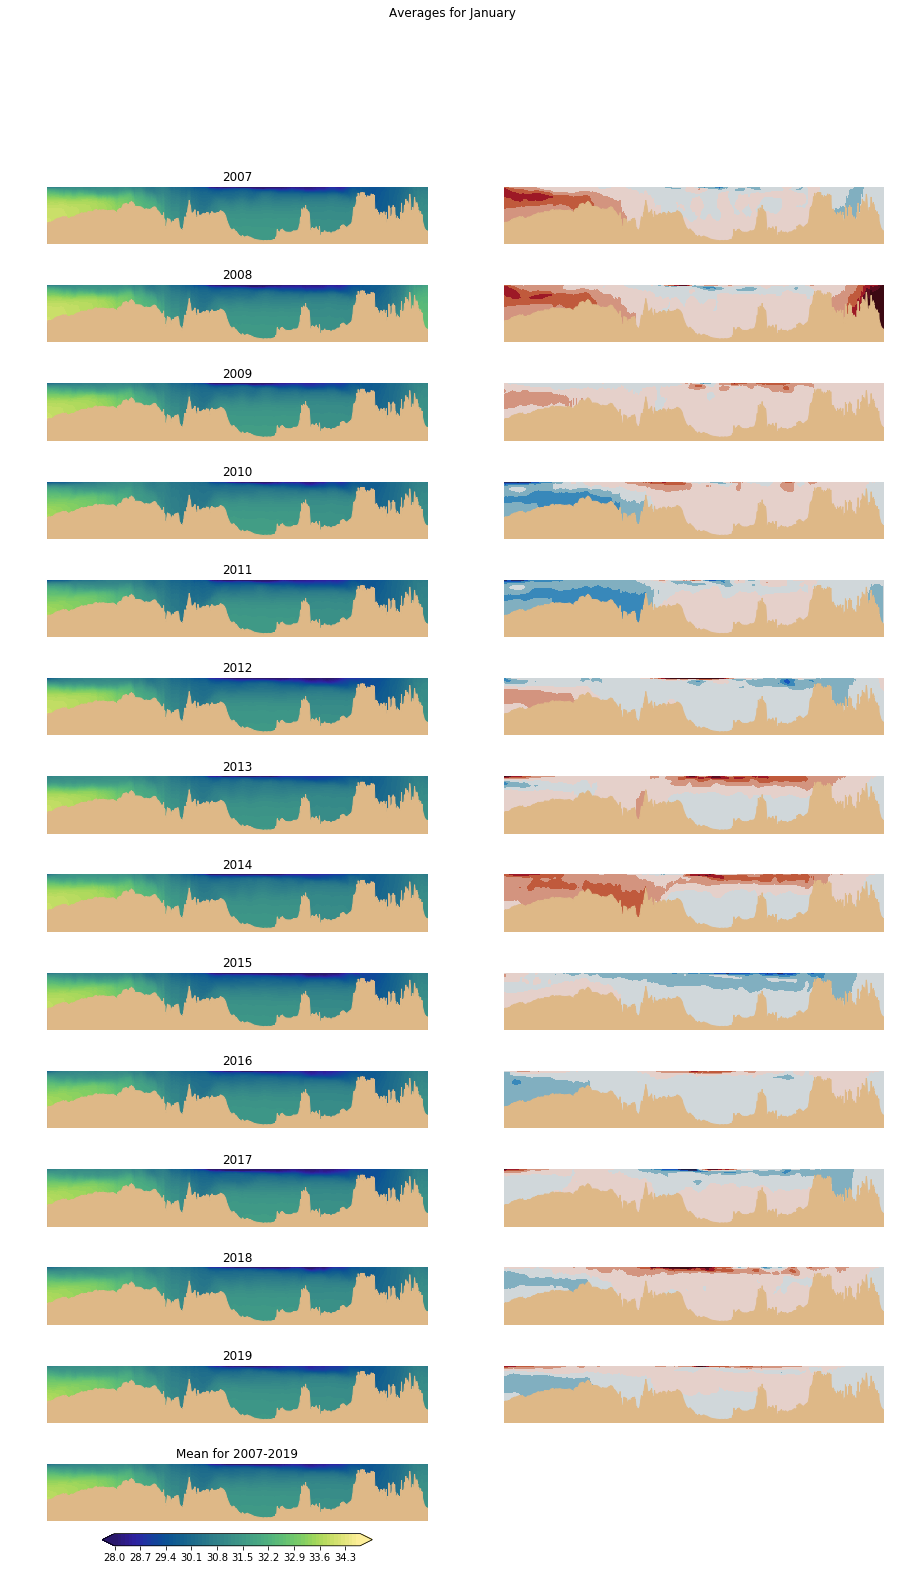

In [187]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 29
vmin = 28
dvmax = 1
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

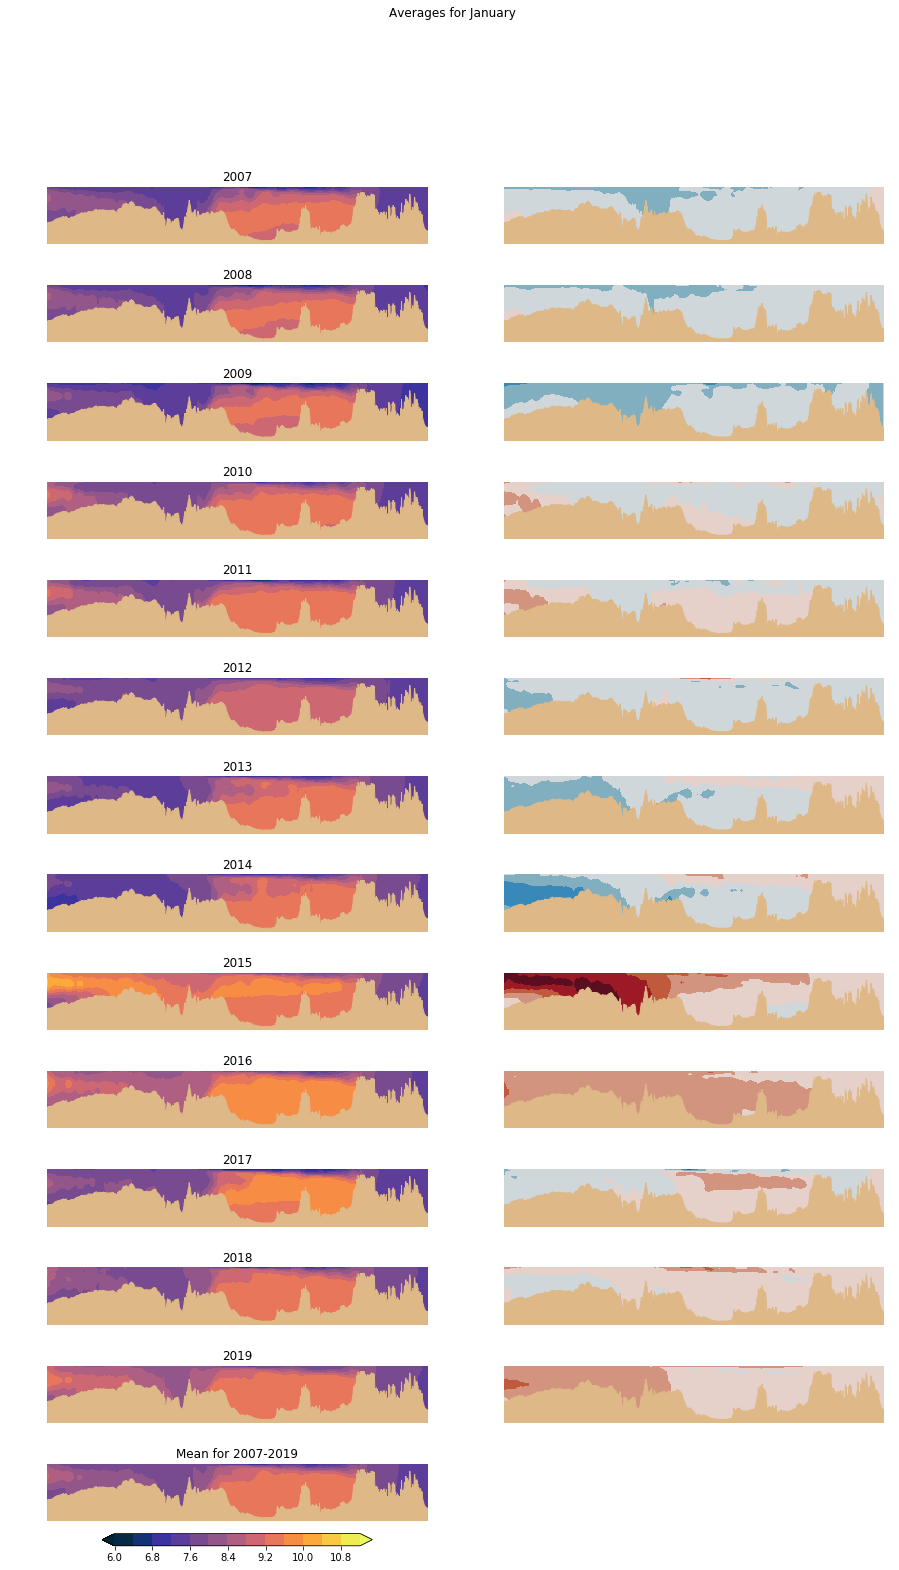

In [188]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 6
dvmax = 2
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

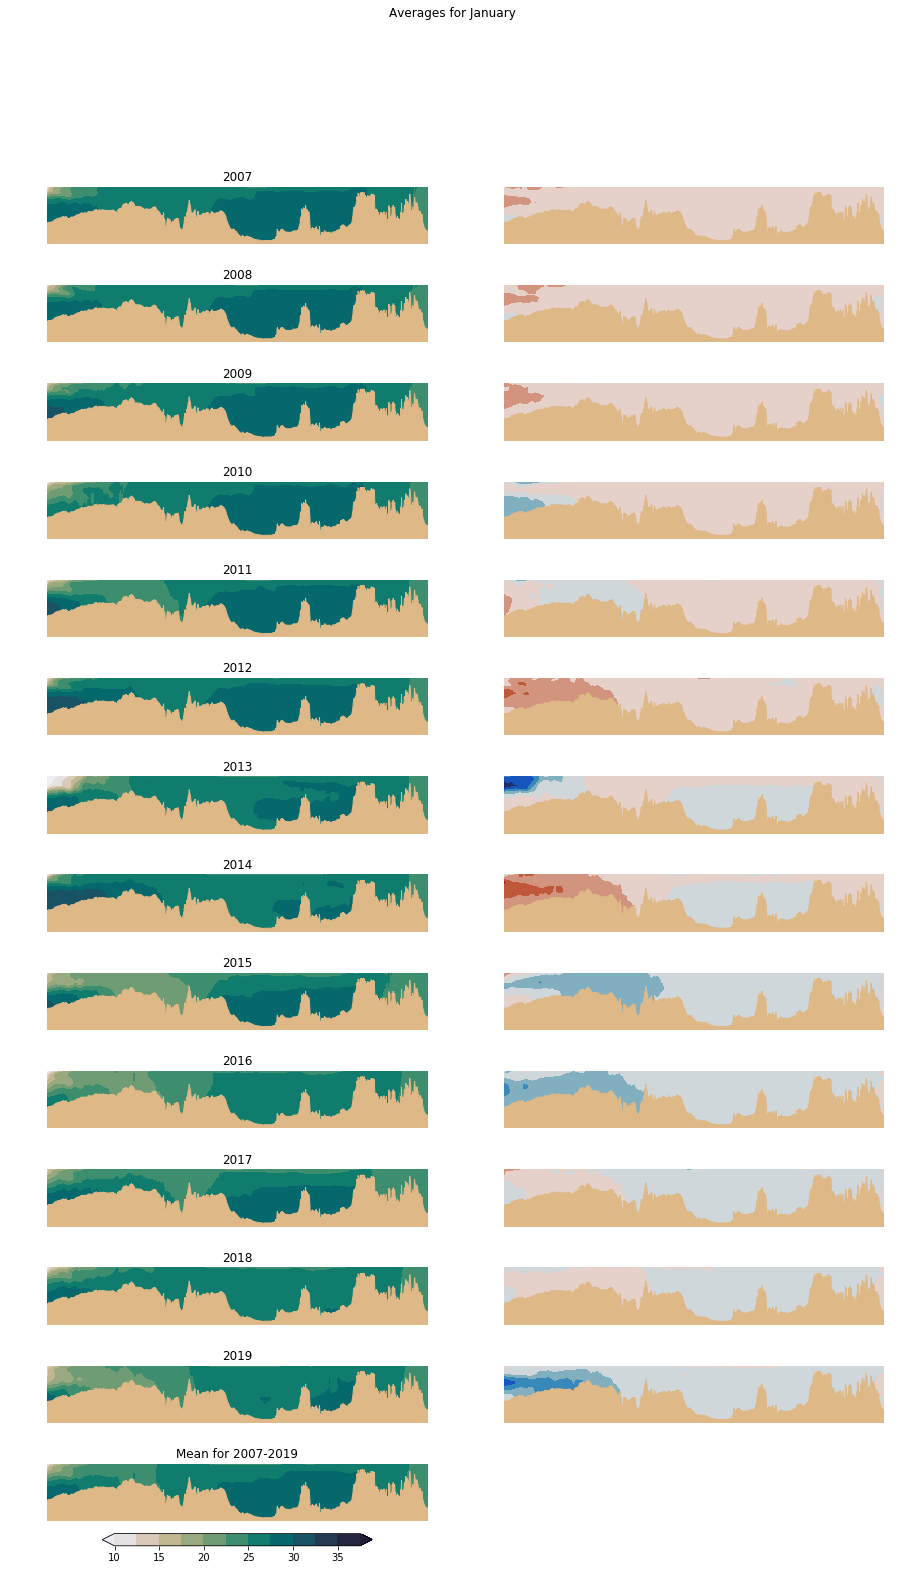

In [189]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 35
vmin = 10
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

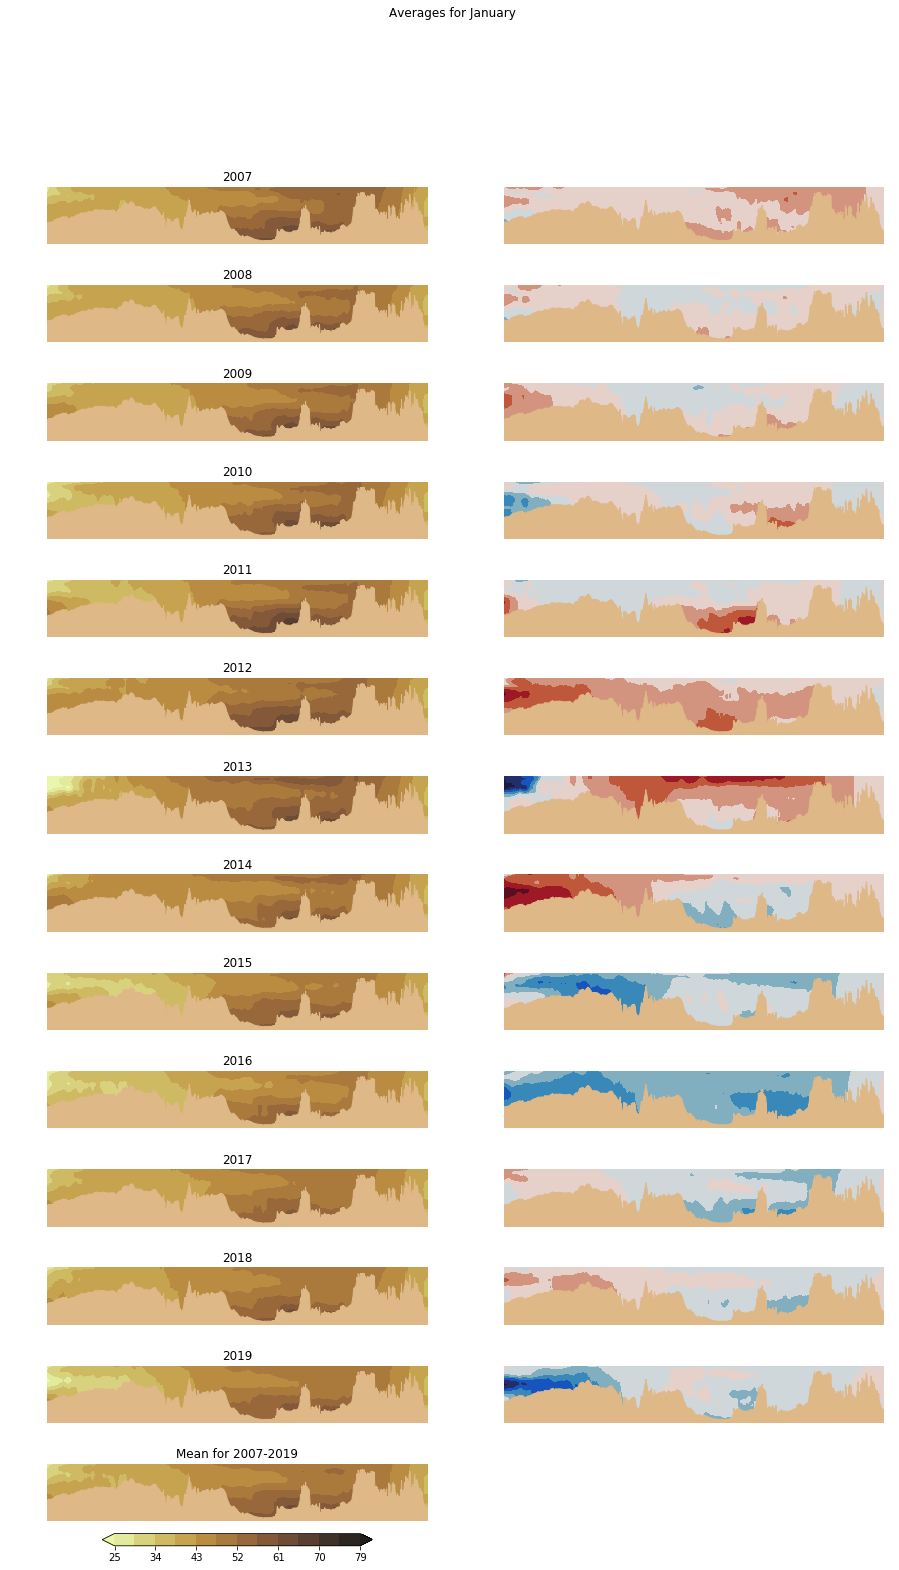

In [190]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 70
vmin = 25
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

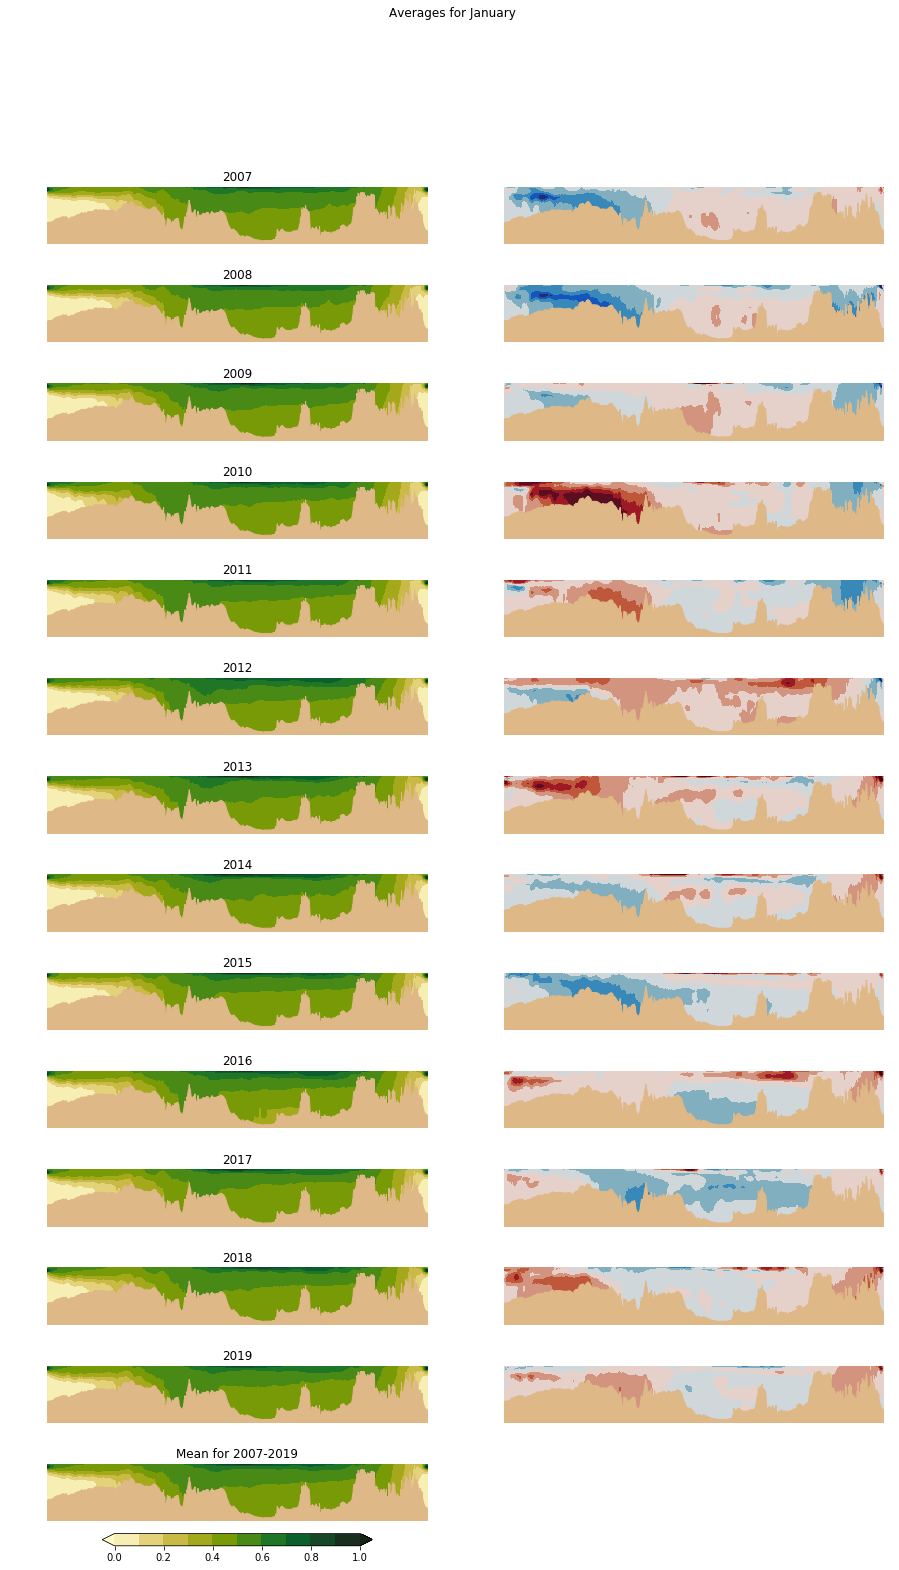

In [191]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.1
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

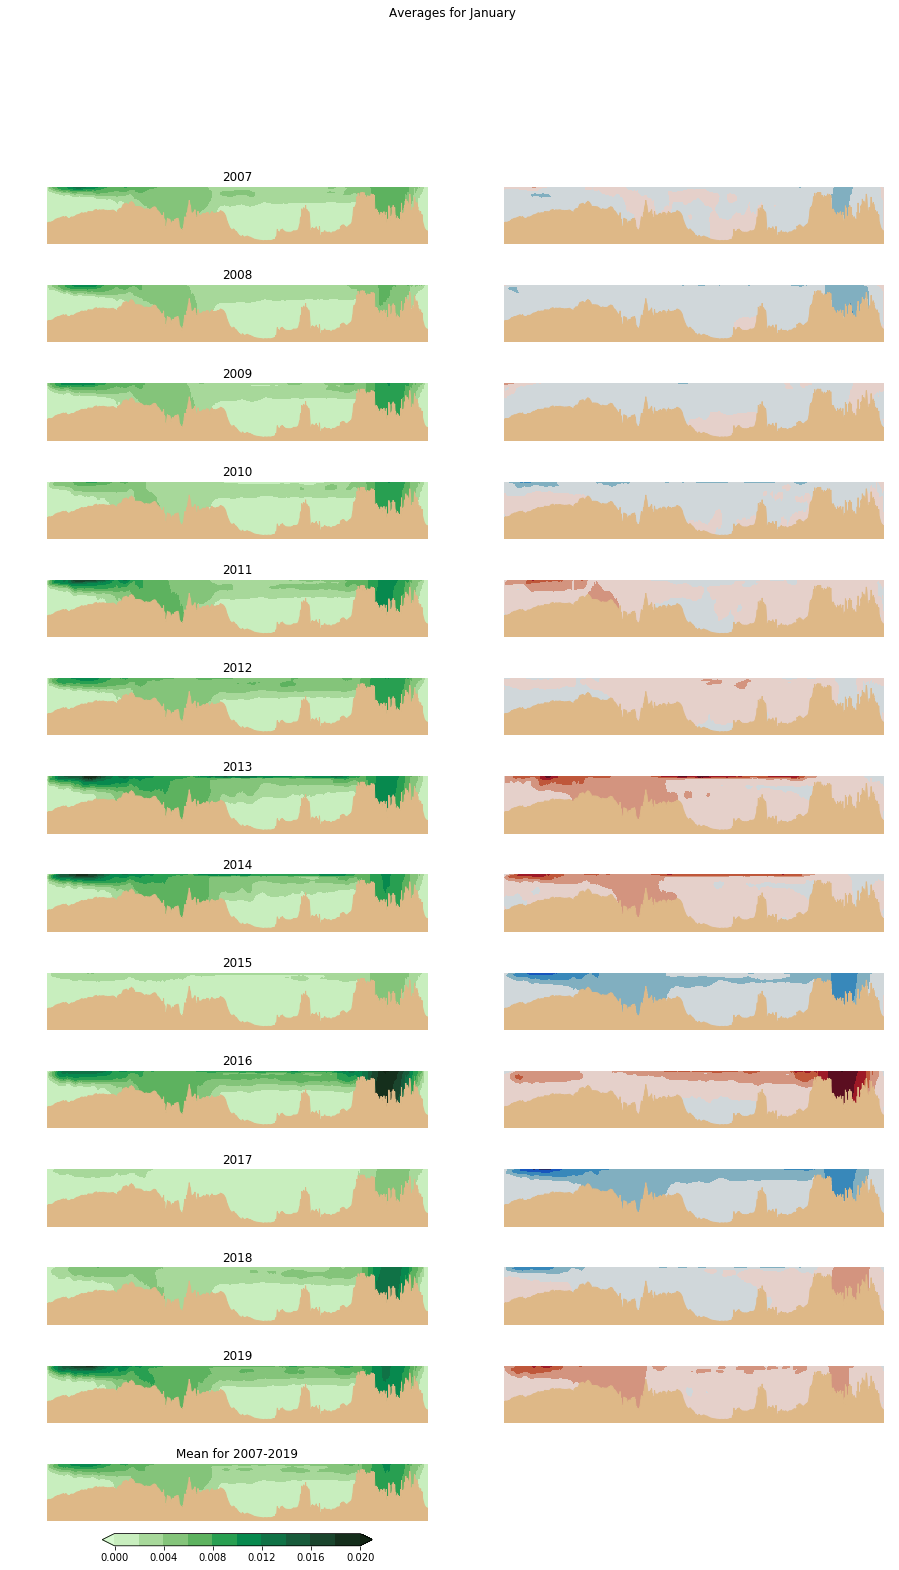

In [192]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.02
vmin = 0
dvmax = 0.01
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

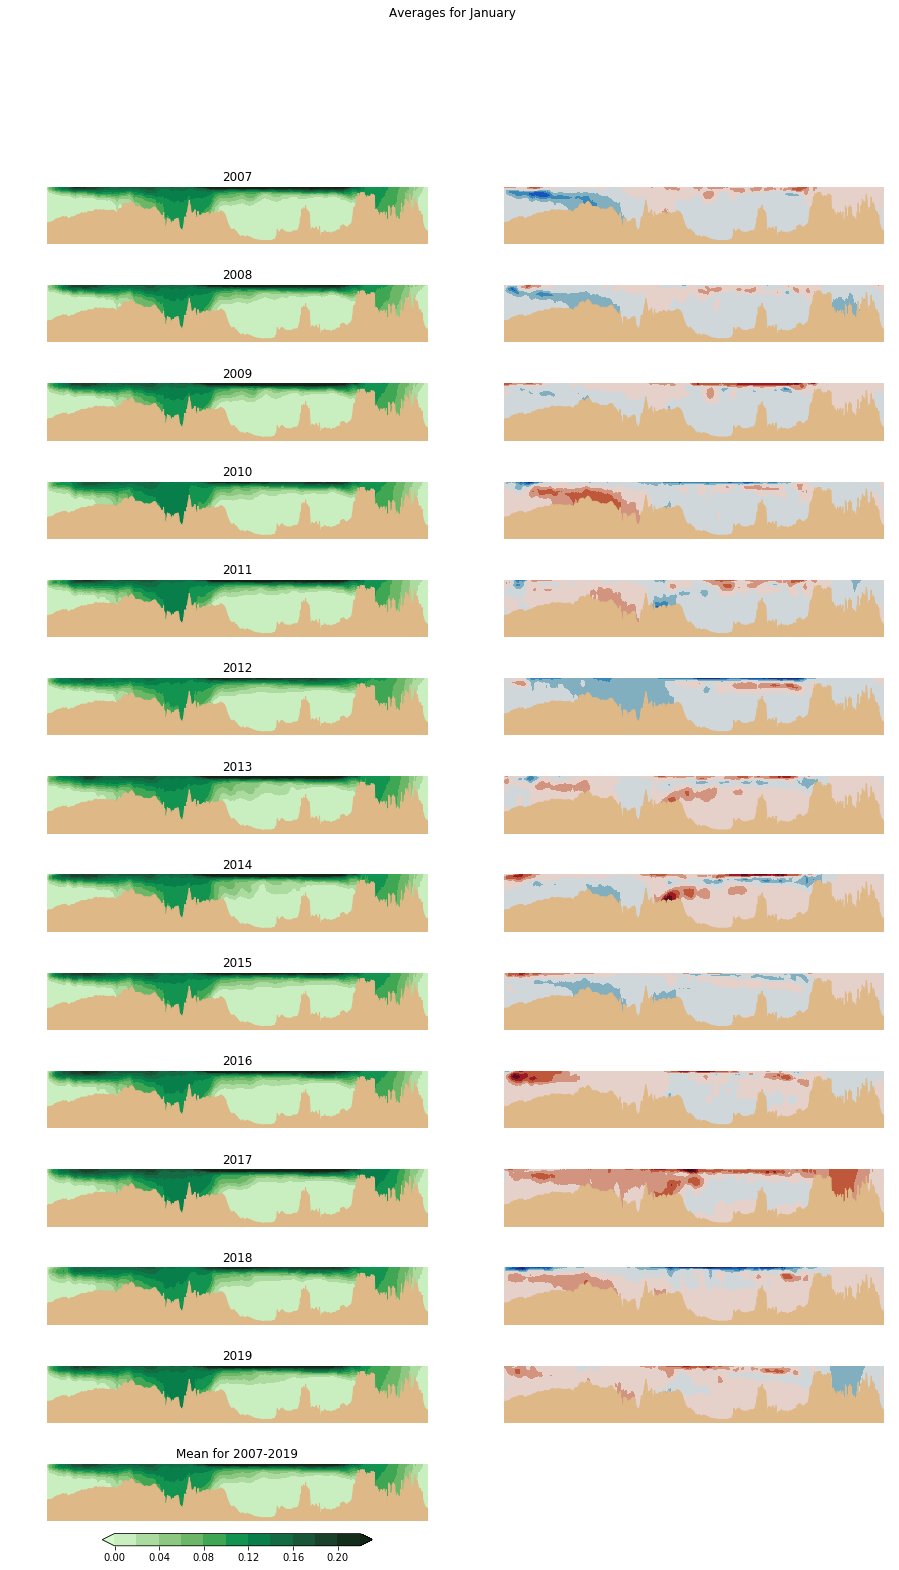

In [193]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.2
vmin = 0
dvmax = 0.05
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

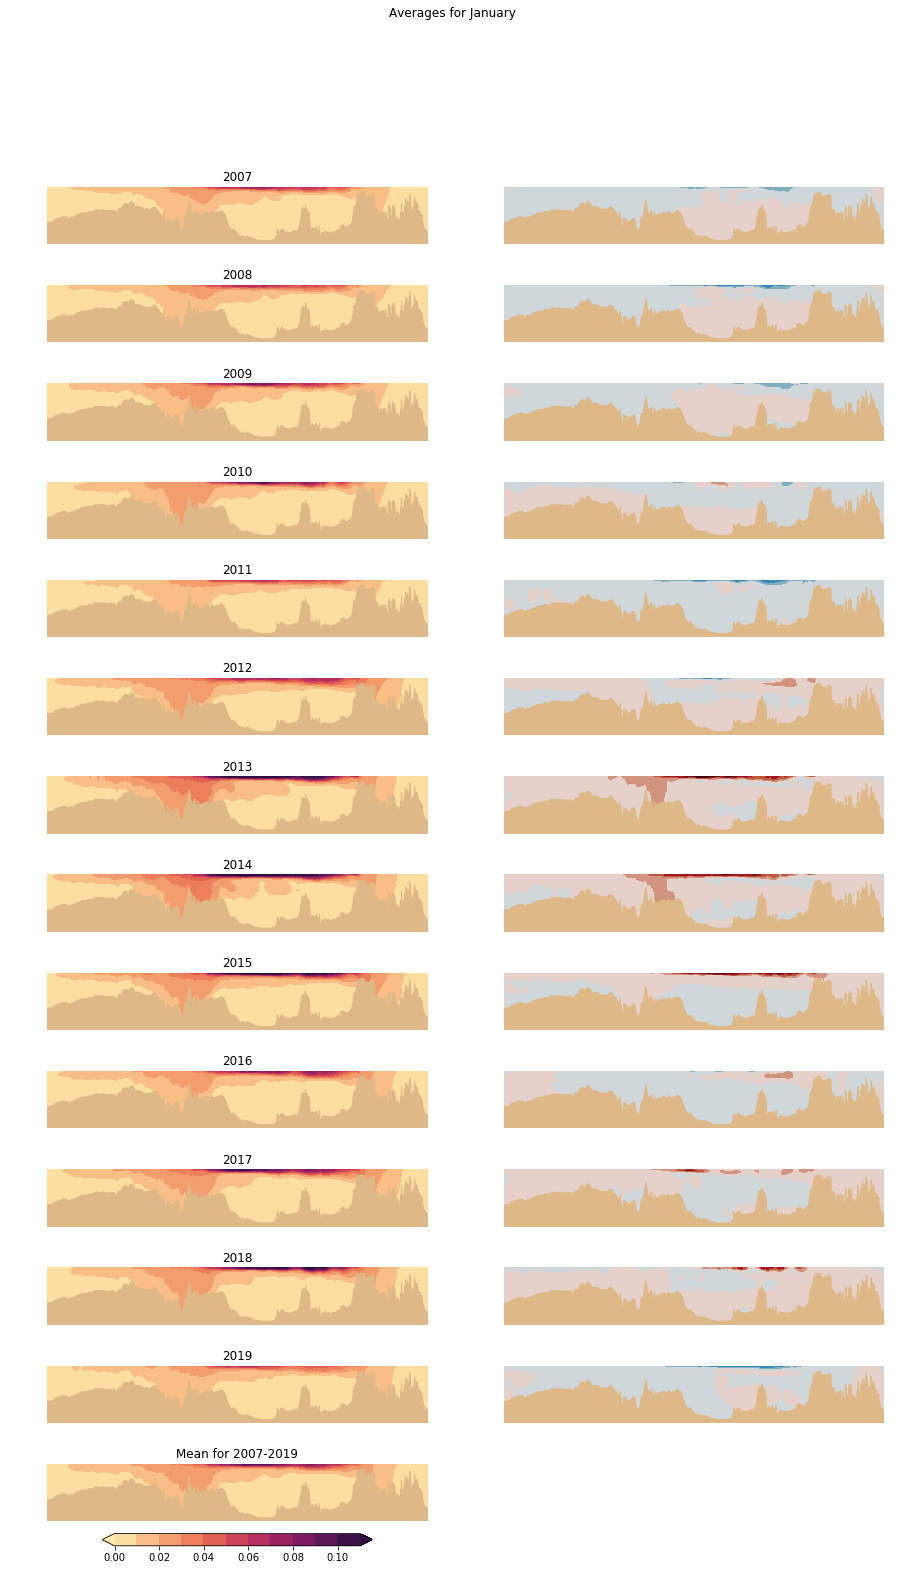

In [194]:
tracer = 'microzooplankton'
file = 'ptrc'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.1
vmin = 0
dvmax = 0.05
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

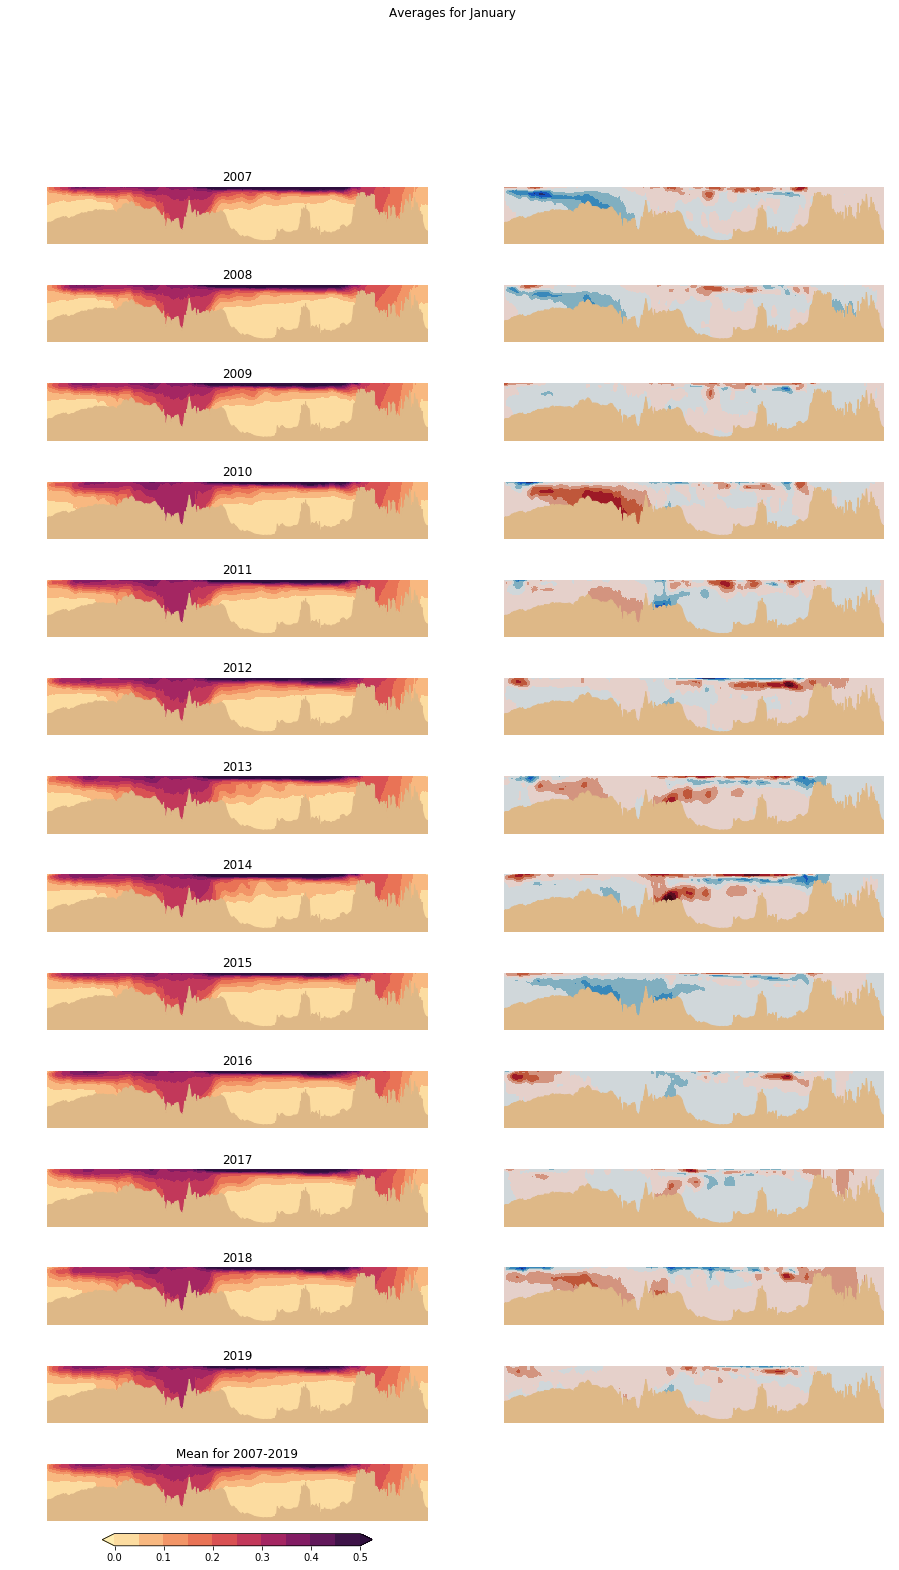

In [195]:
tracer = 'mesozooplankton'
file = 'ptrc'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.5
vmin = 0
dvmax = 0.1
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

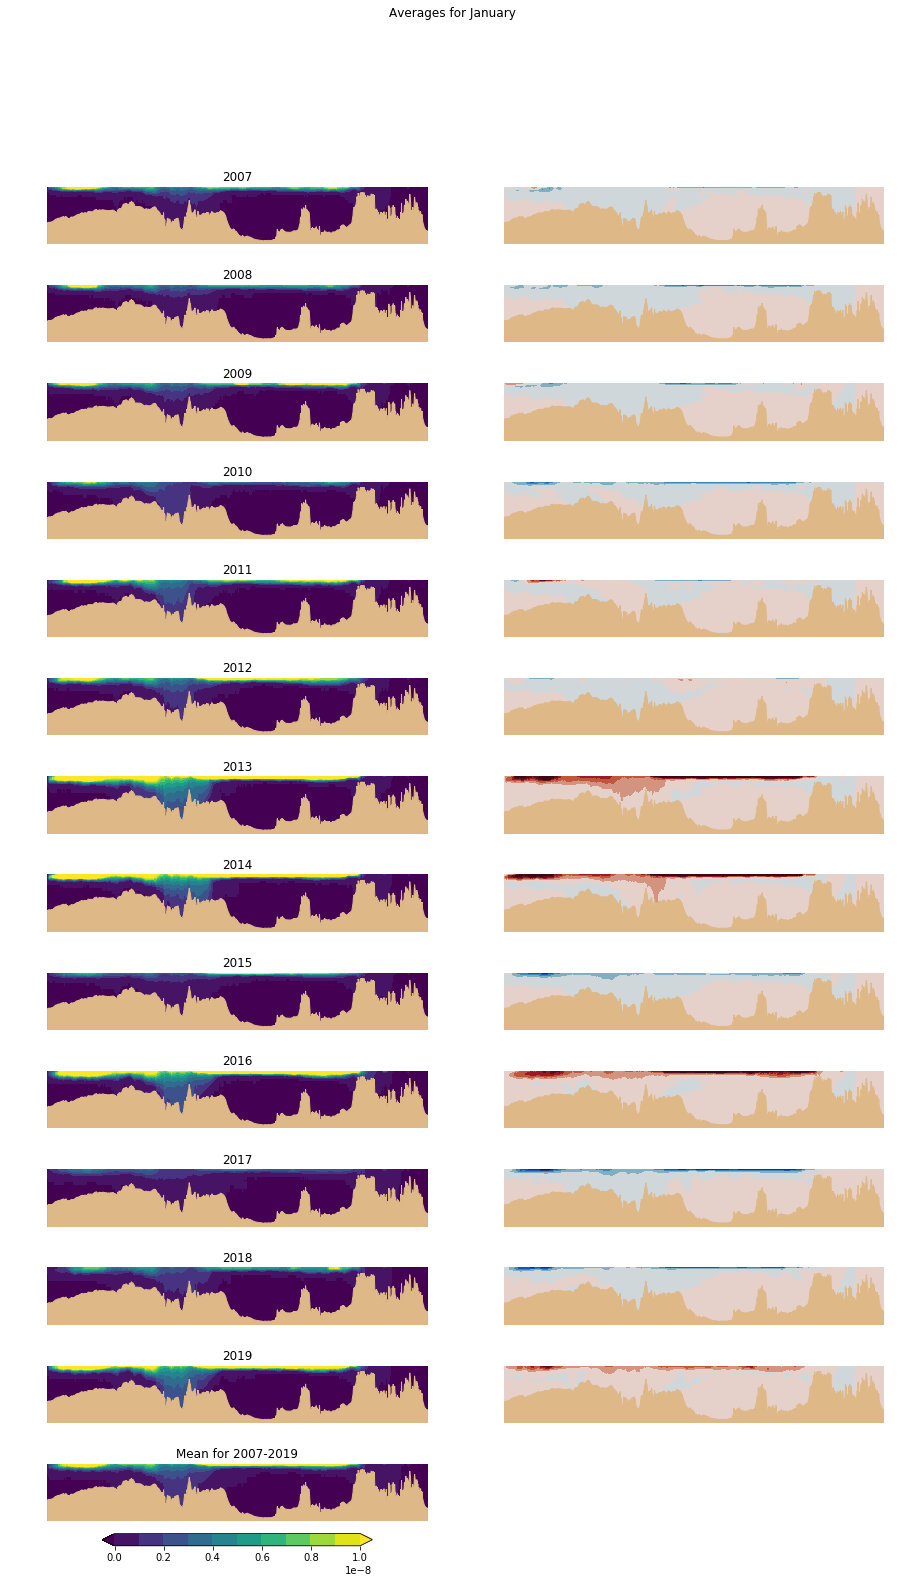

In [196]:
tracer = 'GRMESZDIAT'
file = 'dia2'
cmap = 'viridis'
cdiff = cm.balance
vmax = 1e-8
vmin = 0
dvmax = 1e-8
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

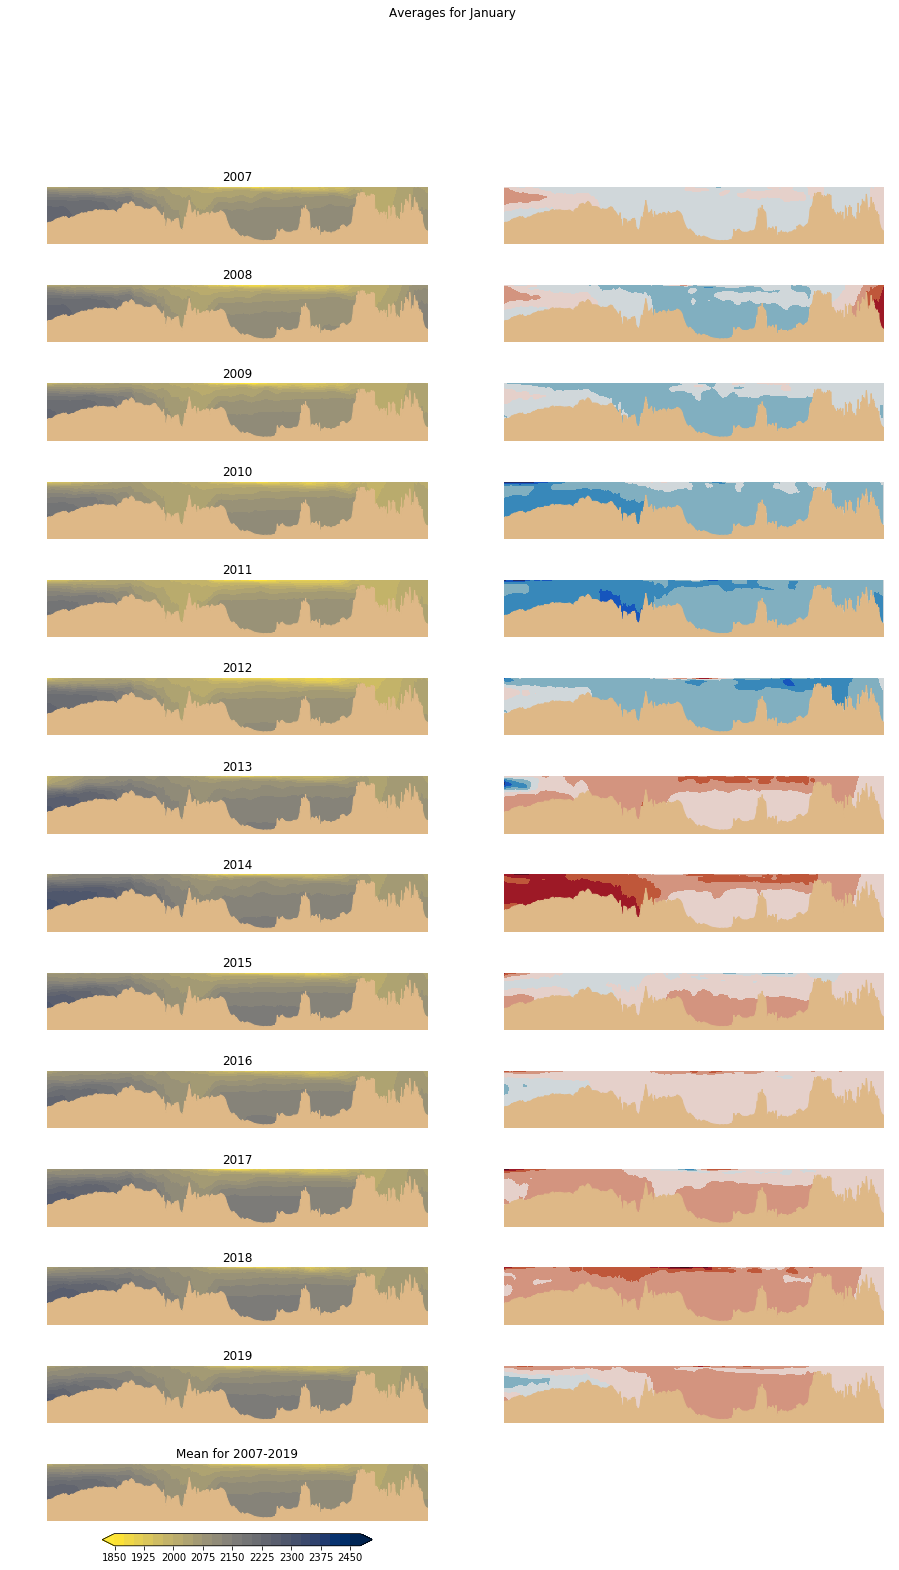

In [197]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2100
vmin = 1850
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

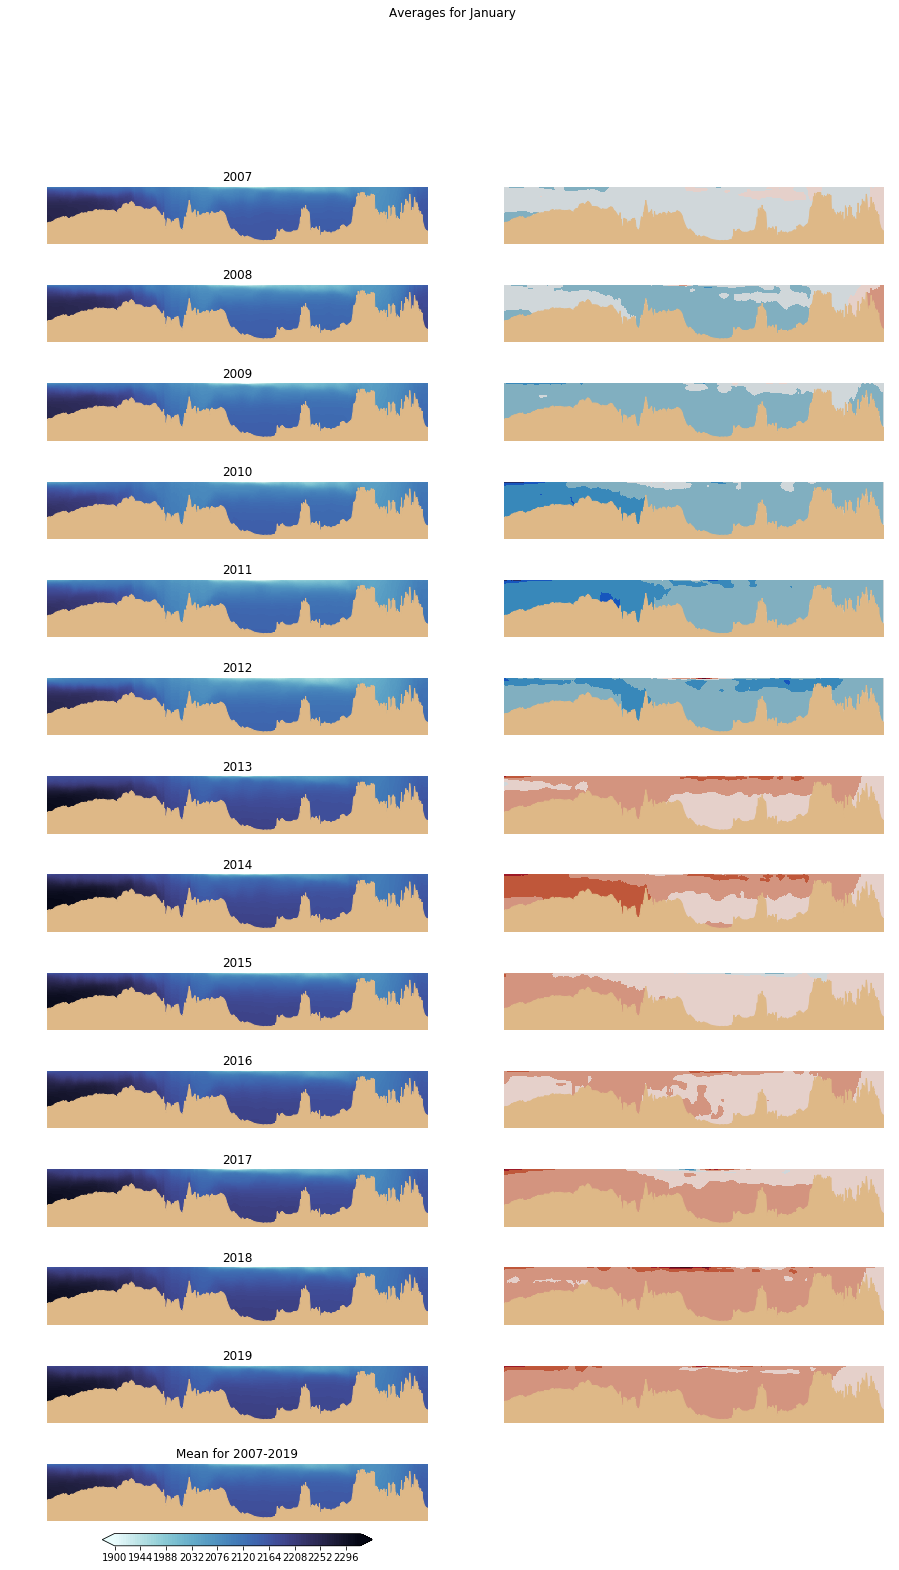

In [198]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cdiff = cm.balance
vmax = 1940
vmin = 1900
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')